In [87]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lumapi import INTERCONNECT 
from scipy.constants import c

In [88]:
inter = INTERCONNECT()

In [89]:
def achar_x_e_y_minimo_em_um_intervalo(funcao, x, xmin, xmax):
    
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(-funcao)
    x_vale = x[peaks]
    y_vale = funcao[peaks]

    for j in range (len(x_vale)):
        if(x_vale[j]< xmax and x_vale[j]>xmin):
            return x_vale[j], y_vale[j]

$$
l_{0} = 2l_{guia} + 2\pi R  
$$

Onde,

$$
2l_{guide} = 1040 \mu m
$$
$$
R = 25 \mu m
$$

Então,

$$
l = l_0(1+S)
$$

Onde,

$$
S = [0,25,50,75,100,125,150] \text{ microstrain}
$$

In [90]:
strains = np.array([0, 25, 50, 75, 100, 125, 150]) * 1e-6
radius = 25e-6
lguias = 1040e-6
Lc = 17.5e-6

comprimentos_totais = (lguias + 2*np.pi*radius)*( 1+strains) 
comprimentos_guias_deformados = (comprimentos_totais-2*np.pi*radius)/2

print("Comprimentos totais: ", comprimentos_totais*1e6, "um")
print("Comprimentos dos guias: ", comprimentos_guias_deformados*1e6, "um")

ng_wd400, neff_wd400 = [4.481929261421695, 2.4640861382563495]
ng_wd1000, neff_wd1000 = [3.908463257808325, 2.9536731212422125]

Comprimentos totais:  [1197.07963268 1197.10955967 1197.13948666 1197.16941365 1197.19934064
 1197.22926763 1197.25919462] um
Comprimentos dos guias:  [520.         520.0149635  520.02992699 520.04489049 520.05985398
 520.07481748 520.08978097] um


In [91]:
caso = ["PDK","IDEAL"]
caso = caso[1]

wd = [400, 1000]
wd = wd[0]


In [92]:
comprimentos_de_onda = []
TE_gain_1 = []

fsr_wv = []
FSR = []

for i in range(len(strains)):
    inter.switchtodesign()
    inter.deleteall()

    inter.addelement('Optical Network Analyzer')
    inter.set("number of points",100000)
    inter.set("number of input ports",2)
    inter.set("input parameter",2)
    inter.set("start frequency", c/(1530e-9))
    inter.set("stop frequency", c/(1565e-9))

    inter.expressioncheckoff()
    if (caso == "PDK"):
        inter.addelement("ebeam_dc_te1550")
        inter.set("coupling_length", Lc)
        inter.set("name", "DC1")

        inter.select("DC1")
        inter.copy()
        inter.set("name","DC2")
        inter.rotateelement("DC1")
        inter.rotateelement("DC1")

        inter.addelement("ebeam_dc_te1550")
        inter.set("coupling_length", Lc)
        inter.set("name", "DC1")

        inter.addelement('ebeam_wg_integral_1550')
        inter.set("name", "Guia_1")
        inter.set("wg_length", comprimentos_guias_deformados[i])
        inter.rotateelement("Guia_1")

        inter.addelement('ebeam_wg_integral_1550')
        inter.set("name", "Guia_2")
        inter.set("wg_length", comprimentos_guias_deformados[i])
        inter.rotateelement("Guia_2")
        
        inter.connect("DC1", "opt_3", "Guia_2", "port 1")
        inter.connect("DC1", "opt_1", "Guia_1", "port 1")
        inter.connect("Guia_1", "port 2", "DC2", "opt_3")
        inter.connect("Guia_2", "port 2", "DC2", "opt_1")
        inter.connect("ONA_1", "output", "DC2", "opt_4")
        inter.connect("ONA_1", "input 1", "DC2", "opt_2") 

    elif(caso == "IDEAL"):
        inter.addelement('Waveguide Coupler')
        inter.set("coupling coefficient 1", 0.2)
        inter.set("name", "DC1")

        inter.select("DC1")
        inter.copy()
        inter.set("name","DC2")

        inter.addelement('Straight waveguide')
        inter.set("name", "Guia_1")
        inter.set("length",comprimentos_totais[i]/2)
        if (wd == 400):
            inter.set("effective index 1", neff_wd400)
            inter.set("group index 1", ng_wd400)
        elif(wd == 1000):
            inter.set("effective index 1", neff_wd1000)
            inter.set("group index 1", ng_wd1000)    
            
        inter.rotateelement("Guia_1")

        inter.select("Guia_1")
        inter.copy()
        inter.set("name", "Guia_2")

        inter.connect("DC1", "port 2", "Guia_2", "port 1")
        inter.connect("DC1", "port 4", "Guia_1", "port 1")
        inter.connect("Guia_1", "port 2", "DC2", "port 3")
        inter.connect("Guia_2", "port 2", "DC2", "port 1")
        inter.connect("ONA_1", "output", "DC2", "port 4")
        inter.connect("ONA_1", "input 1", "DC2", "port 2") 

    inter.setposition("ONA_1",440,440)
    inter.setposition("DC1",0,175)
    inter.setposition("DC2",0,175*3)
    inter.setposition("Guia_1",220,175*2)
    inter.setposition("Guia_2",-220,175*2)

    inter.run()

    TE_gain_1.append(np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["TE gain (dB)"]))

    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv.append(np.squeeze(FSR1['wavelength']))
    FSR.append(FSR1["TE free spectral range (m)"])

    comprimentos_de_onda.append(np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['wavelength']))

# Resonance shift versus strain

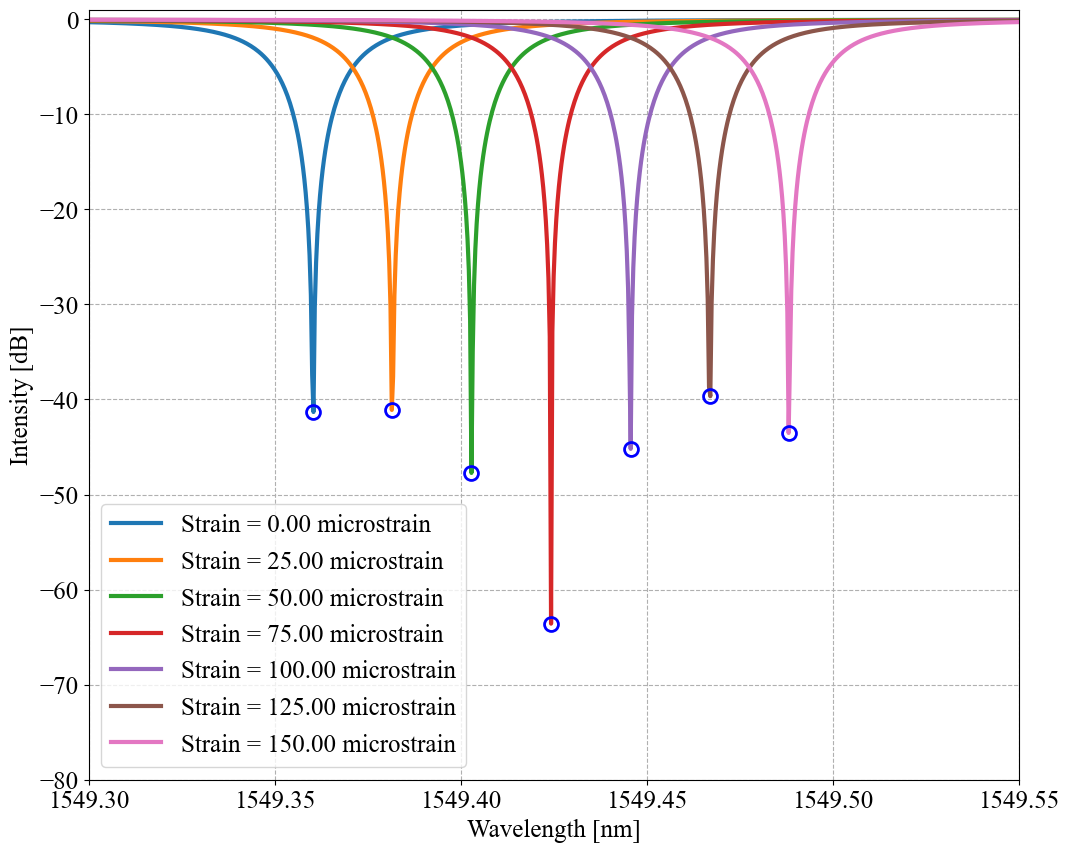

In [100]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'  # ou Arial, Times New Roman, etc.
mpl.rcParams['font.size'] = 18           # tamanho padrão do texto

plt.figure(figsize=(12,10))

wvg_min = 1549.3
wvg_max = 1549.55

for i in range(len(strains)):
    plt.plot(comprimentos_de_onda[i]*1e9,TE_gain_1[i],linewidth = 3,label = f"Strain = {strains[i]*1e6:.2f} microstrain")
    x_minimo, y_minimo = achar_x_e_y_minimo_em_um_intervalo(TE_gain_1[i],comprimentos_de_onda[i]*1e9, wvg_min, wvg_max)
    plt.plot(x_minimo,y_minimo, "o-",color ='b',markersize = 10, markerfacecolor='none',markeredgewidth =2)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [dB]')

plt.tick_params(axis='both')

plt.ticklabel_format(style='plain', axis='x')
# Formata o eixo x com 1 casa decimal
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.legend(loc = "best")

plt.xlim(wvg_min,wvg_max)
plt.ylim(-80,1)
plt.grid(True, linestyle='--')

plt.savefig(f"C:/Users/gson5/Downloads/Photonics-API-lumapi/RING - STRAIN/RESULTADOS/TRANSMISSÃO {caso} WD - {wd} nm.jpg", bbox_inches='tight')

plt.show()



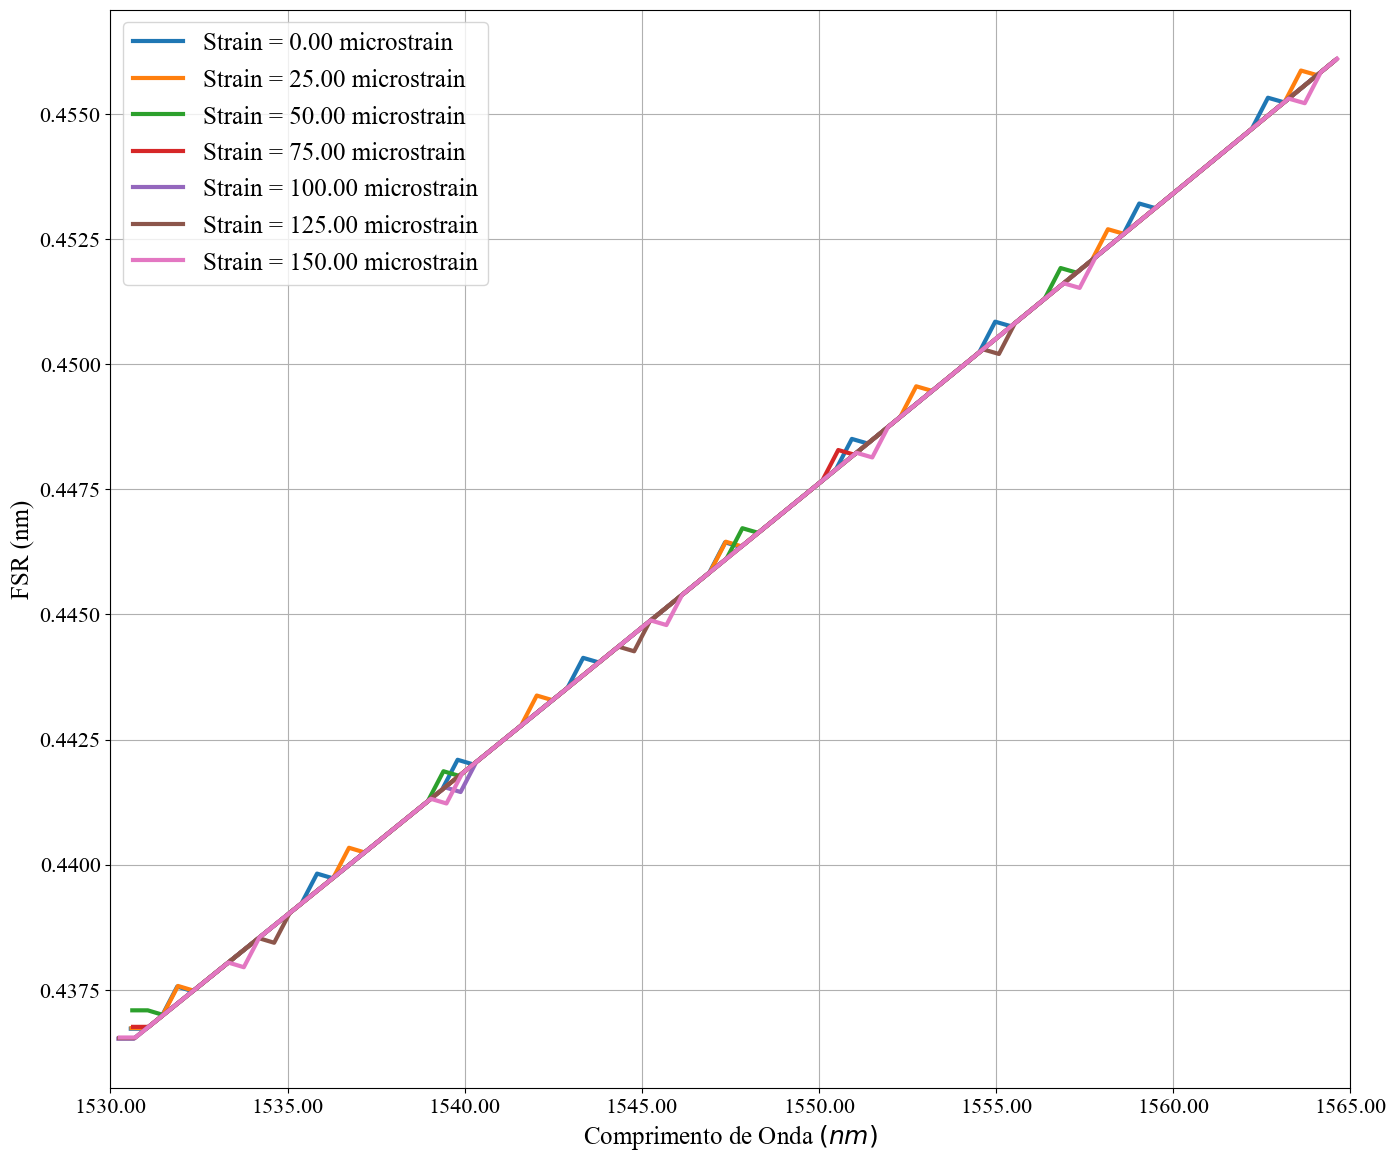

In [94]:

plt.figure(figsize=(16,14))

for i in range(len(strains)):
    plt.plot(fsr_wv[i]*1e9,FSR[i]*1e9,linewidth = 3,label = f"Strain = {strains[i]*1e6:.2f} microstrain")

plt.xlabel('Comprimento de Onda $(nm)$')
plt.ylabel('FSR (nm)')

plt.tick_params(axis='both', labelsize=16)

plt.ticklabel_format(style='plain', axis='x')
# Formata o eixo x com 1 casa decimal
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.legend(loc = "best")

wvg_min = 1530
wvg_max = 1565
plt.xlim(wvg_min,wvg_max)
plt.grid(True)

plt.savefig(f"C:/Users/gson5/Downloads/Photonics-API-lumapi/RING - STRAIN/RESULTADOS/FSR {caso} WD - {wd} nm.jpg", bbox_inches='tight')

plt.show()

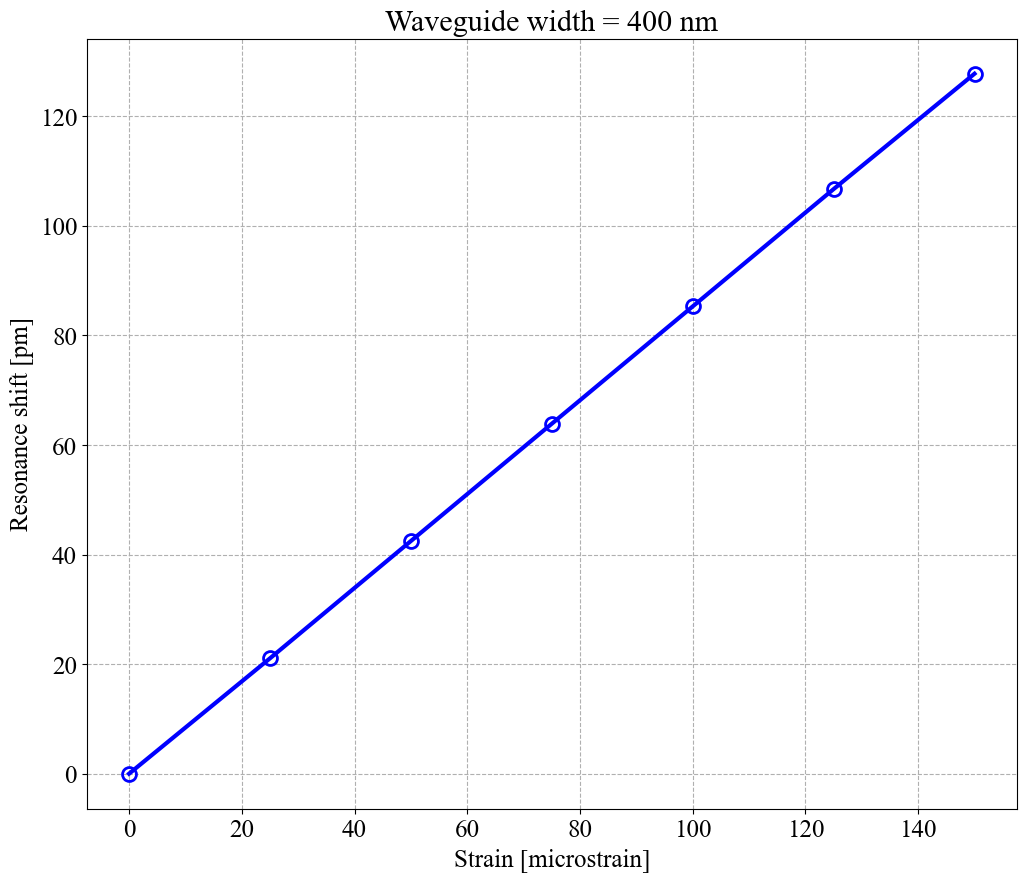

In [101]:
wvg_vale = []

for i in range(len(strains)):
    x_min, _ = achar_x_e_y_minimo_em_um_intervalo(TE_gain_1[i],comprimentos_de_onda[i]*1e9, wvg_min, wvg_max)
    wvg_vale.append(x_min*1e-9)

wvg_shift = (wvg_vale - wvg_vale[0])

plt.figure(figsize=(12,10))
plt.plot(strains*1e6, wvg_shift*1e12, "o-" ,color='b',linewidth =3, markersize=10,markeredgewidth=2,markerfacecolor = 'none')
plt.title(f"Waveguide width = {wd} nm")
plt.grid(True,linestyle = '--')
plt.xlabel("Strain [microstrain]")
plt.ylabel("Resonance shift [pm]")

plt.savefig(f"C:/Users/gson5/Downloads/Photonics-API-lumapi/RING - STRAIN/RESULTADOS/RESONANCE SHIFT VS STRAIN {caso} WD - {wd} nm.jpg", bbox_inches='tight')

plt.show()


# Shift versus resonance wavelength

In [102]:
import math as mt

intervalos_minimos = []

FSR_aprox = (min(FSR[0]) + max(FSR[0]))*1e9/2
comprimento_minimo = 1545.2
comprimento_maximo = 1555

qtd_vales = mt.ceil((comprimento_maximo - comprimento_minimo)/FSR_aprox)+1

for i in range(qtd_vales):
    intervalos_minimos.append(comprimento_minimo + FSR_aprox*i)

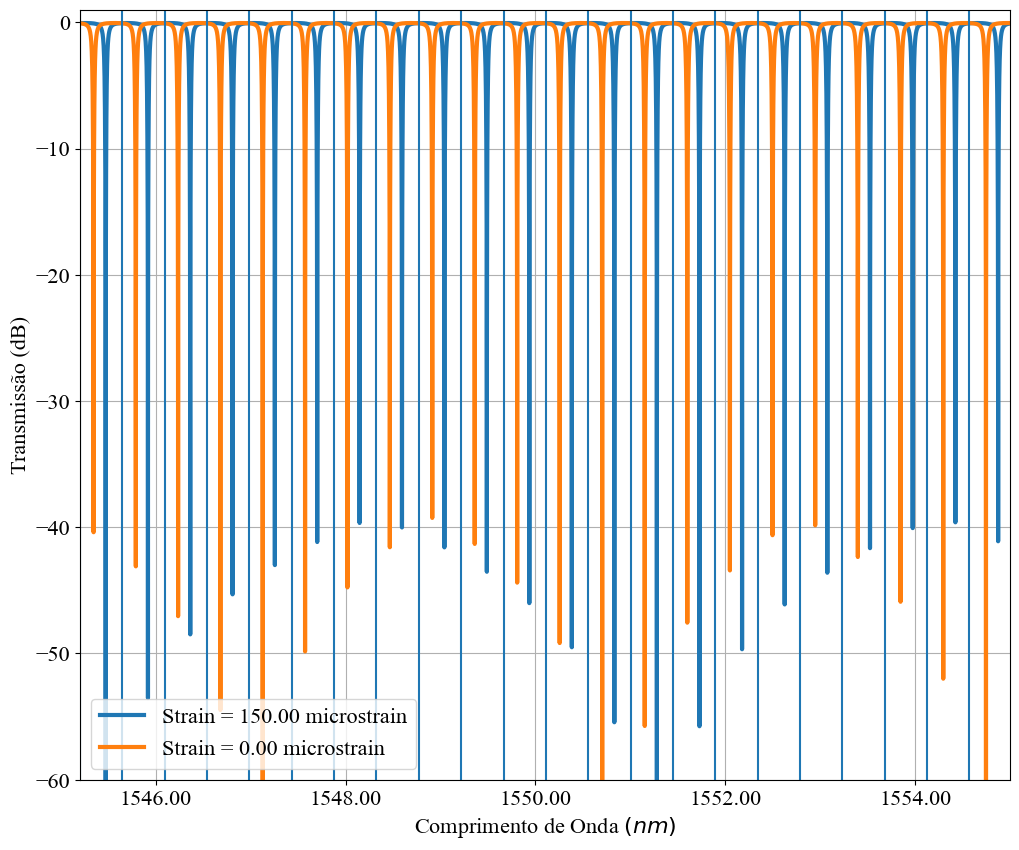

In [103]:
plt.figure(figsize=(12,10))

plt.plot(comprimentos_de_onda[6]*1e9,TE_gain_1[6],linewidth = 3,label = f"Strain = {strains[6]*1e6:.2f} microstrain")
plt.plot(comprimentos_de_onda[0]*1e9,TE_gain_1[0],linewidth = 3,label = f"Strain = {strains[0]*1e6:.2f} microstrain")

for i in range(qtd_vales):
    plt.axvline(x = intervalos_minimos[i])

plt.xlabel('Comprimento de Onda $(nm)$', fontsize = 16)
plt.ylabel('Transmissão (dB)', fontsize = 16)

plt.tick_params(axis='both', labelsize=16)

plt.ticklabel_format(style='plain', axis='x')
# Formata o eixo x com 1 casa decimal
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.legend(loc = "best", fontsize = 16)

plt.xlim(comprimento_minimo,comprimento_maximo)
plt.ylim(-60,1)
plt.grid(True)
plt.show()

In [104]:
wvg_vales = np.zeros((len(intervalos_minimos)-1, len(strains)))
shift = np.zeros((len(intervalos_minimos)-1, len(strains)))
coef_angular = np.zeros((len(intervalos_minimos)-1))

for j in range(len(intervalos_minimos)-1):
    for i in range(len(strains)):
        x_min, _ = achar_x_e_y_minimo_em_um_intervalo(TE_gain_1[i],
                                                      comprimentos_de_onda[i]*1e9, 
                                                      intervalos_minimos[j], 
                                                      intervalos_minimos[j+1])
        wvg_vales[j,i] = x_min*1e-9
        shift[j,i] = (wvg_vales[j,i] - wvg_vales[j,0])
    
    coef_angular[j] = (shift[j,-1]-shift[j,0])*1e12/((strains[-1] - strains[0])*1e6)

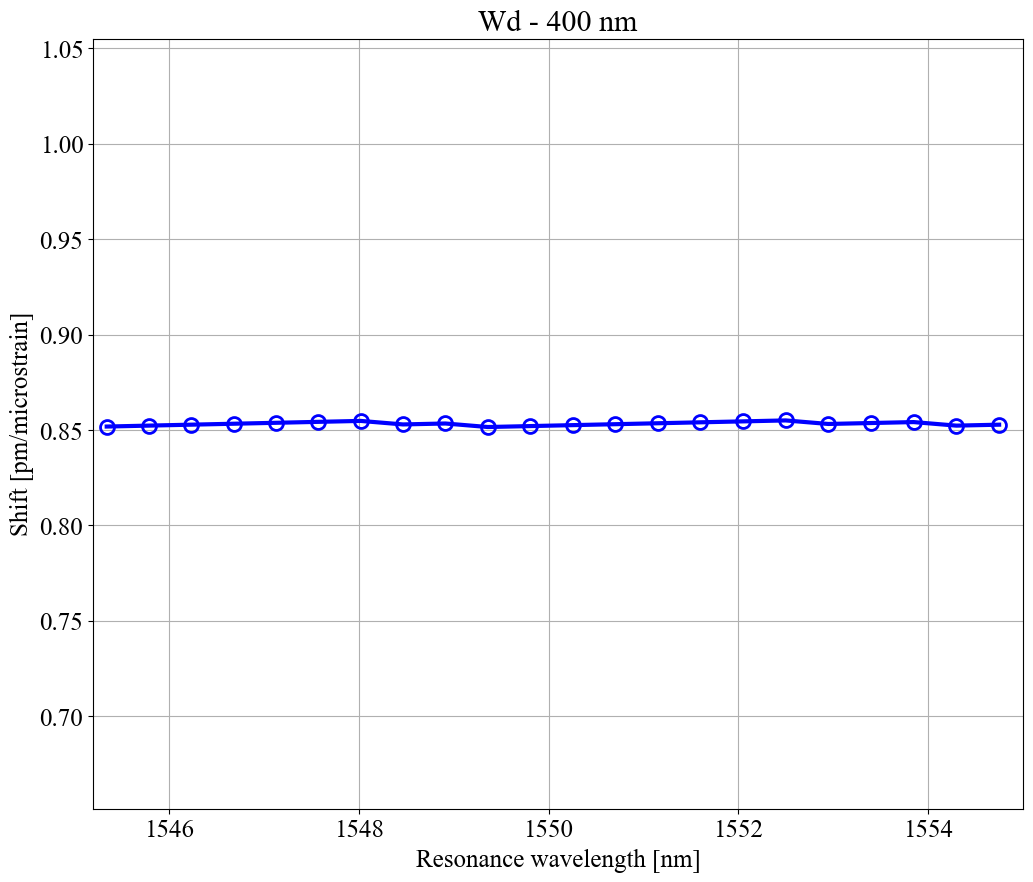

In [105]:

plt.figure(figsize=(12,10))
plt.plot(wvg_vales[:,0]*1e9, coef_angular, '-o',color = 'b', linewidth = 3, markersize=10,markeredgewidth=2,markerfacecolor = 'none')
plt.xlabel("Resonance wavelength [nm]")
plt.ylabel("Shift [pm/microstrain]")
plt.title(f"Wd - {wd} nm")
plt.ylim(min(coef_angular)-0.2,max(coef_angular)+0.2)
plt.xlim(comprimento_minimo,comprimento_maximo)
plt.grid(True)

plt.savefig(f"C:/Users/gson5/Downloads/Photonics-API-lumapi/RING - STRAIN/RESULTADOS/SHIFT VS RESONANCE WAVELENGTH {caso} WD - {wd} nm.jpg", bbox_inches='tight')

plt.show()